In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
import datetime
import numpy as np

## Dataset
I tried to use the API directly but it seems there is some issue (which the owner of the dataset should perhaps be warned about)

The dataset is here 
https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-by-Week-Sex-and-Age/vsak-wrfu

In [172]:
# load data
data = pd.read_csv("Provisional_COVID-19_Deaths_by_Week__Sex__and_Age.csv")

In [173]:
# this dictionary describes the coars graining of the age groups
my_age_groups = {
    'all_ages': ['All Ages'],
    '0-64': ['Under 1 year', '1-4 Years', '5-14 Years','15-24 Years', '25-34 Years', '35-44 Years', '45-54 Years', '55-64 Years'],
    '65-74': ['65-74 Years'],
    '75-84': ['75-84 Years'],
    '85+': ['85 Years and Over']
}

In [174]:
# not entirely sure this is the most elegant way to group the data,
# but I am creating column with the coarse-grained group each fine-grained group belongs to
# to do that, I am inverting the my_age_groups dictionary (pretty sure there are better ways than this...)

my_age_groups_r = {}

for my_age_group, age_groups in my_age_groups.items():

    for age_group in age_groups:

        my_age_groups_r[age_group] = my_age_group

In [175]:
# creates the extra column
data["age_bins"] = data["Age Group"].apply(lambda x: my_age_groups_r[x])

In [176]:
# makes sure the "End Week" field is datetime
data["End Week"] = pd.to_datetime(data["End Week"])

In [177]:
# grouping the data by my age bins
df = (
    data[data.Sex == "All Sex"][["End Week","COVID-19 Deaths","age_bins"]]
    .groupby(by = ["End Week","age_bins"])
    .sum()
    .reset_index()
    .pivot_table(index = "End Week", columns = "age_bins", values = "COVID-19 Deaths")
)

# dataframes used to plot without worrying too much
df_to_plot = df[["0-64","65-74","75-84","85+"]]

df_tot_to_plot = df[["all_ages"]]

# dataframe fro the percentages
df_to_plot_perc = df_to_plot.divide(df_to_plot.sum(axis=1), axis=0)

## Plot

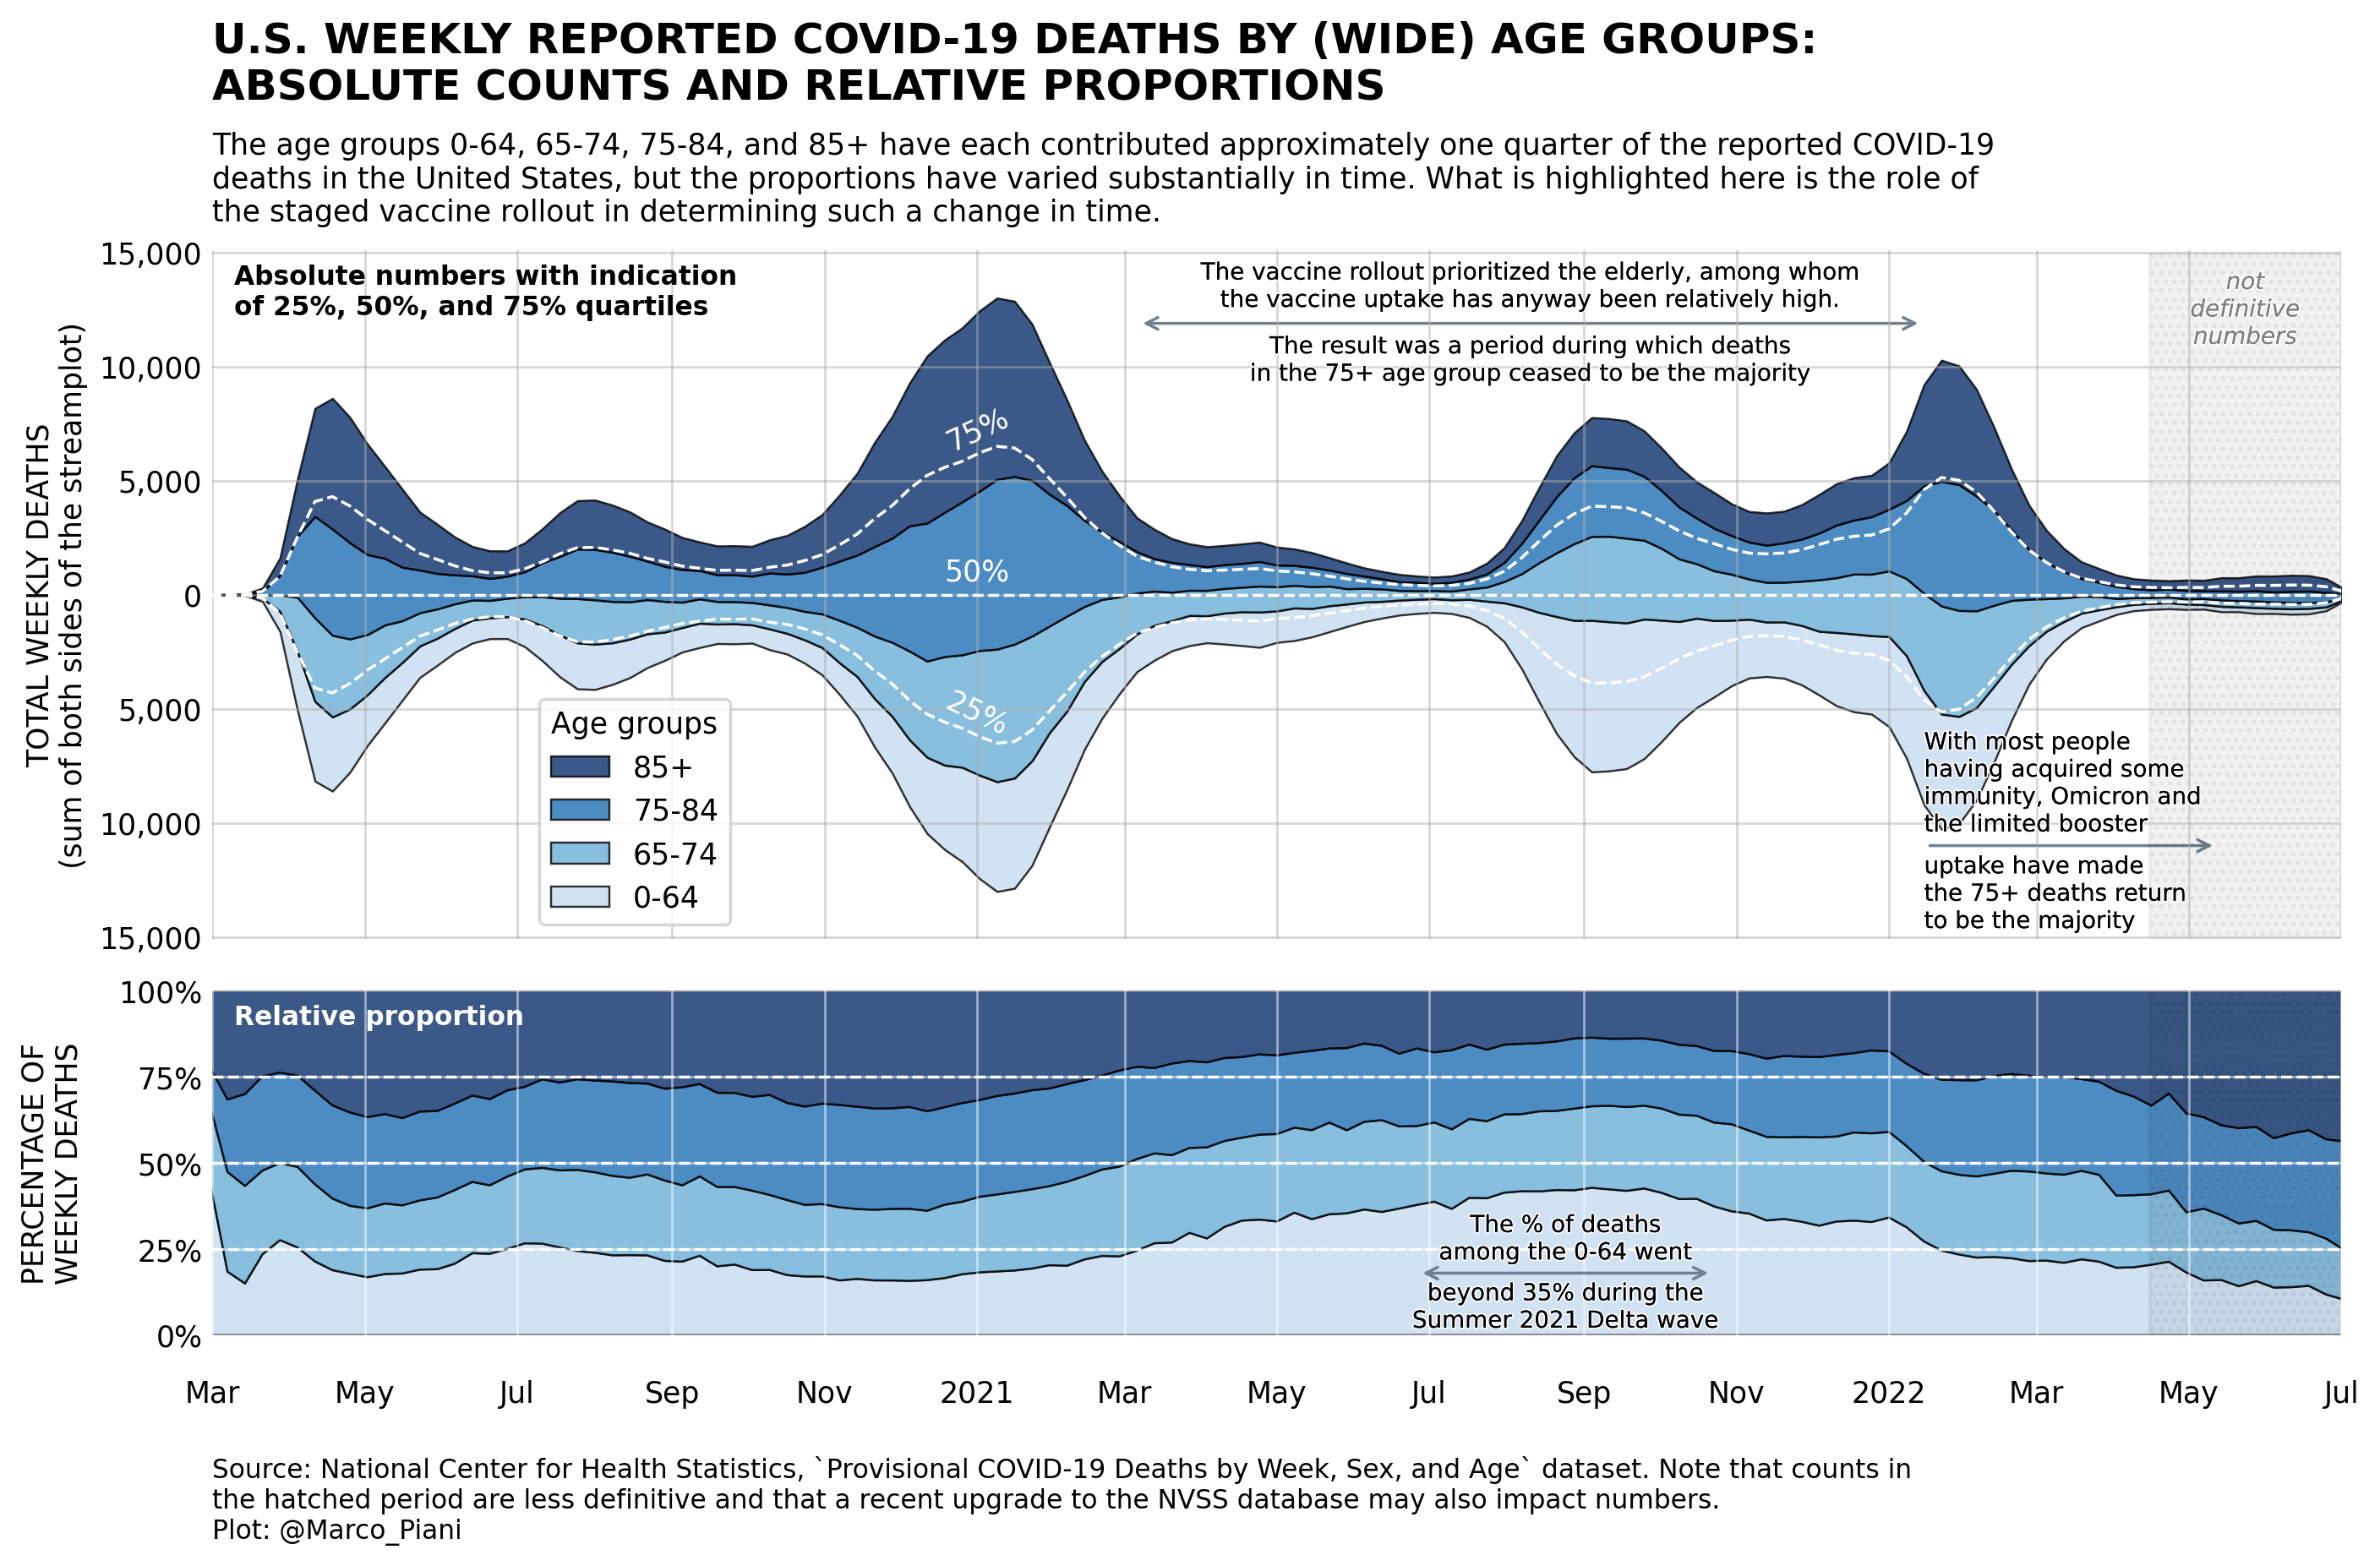

In [178]:
# figures and axes setup

fig, [ax,ax_perc] = plt.subplots(
    figsize = (13,6.8),
    nrows = 2,
    sharex = True,
    dpi = 250,
    gridspec_kw = {
        # controls the ration of the vertical space between the two graphs and the space between the two
        "height_ratios": [2,1],
        "hspace": 0.1
    }
)

# colors for our four groups
my_colors = cm.get_cmap("Blues")([0.25,0.5,0.75,1])

# absolute numbers stream graph
ax.stackplot(
    df_to_plot.index, [ df_to_plot[column] for column in df_to_plot], alpha = 0.8, lw = 0.7, edgecolor = "k", baseline = "sym",
    labels = ["0-64","65-74","75-84","85+"], colors = my_colors
)

# proportion 100% stacked area graph
ax_perc.stackplot(
    df_to_plot_perc.index, [ df_to_plot_perc[column] for column in df_to_plot_perc], alpha = 0.8, lw = 0.7, edgecolor = "k",
    colors = my_colors
)

# loop for
for k in range(1,4):
    
    # plotting quartiles in streamgraph
    # Explainer for "df_tot_to_plot["all_ages"]*(-0.5+k/4)":
    # - streamgraphs are nothing but stacked area charts where the baseline is not zero/flat
    # - since we deal with a symmetric streamplot, we start at negative half the total
    # - every quartite then just goes up 1/4 of the total
    ax.plot(df_tot_to_plot.index, df_tot_to_plot["all_ages"]*(-0.5+k/4), ls = "--", c = "w", lw = 1)
    # this just plots the quartile lines in the 100% stacked chart
    ax_perc.hlines(k/4,datetime.datetime(2020,3,1), datetime.datetime(2022,7,15), ls = "--", color = "w", lw = 1)

    # this takes care of labelling the quartile lines in the streamgraph
    ax.text(
        datetime.datetime(2021,1,1),
        df_tot_to_plot.loc[datetime.datetime(2021,1,2),"all_ages"]*(-0.5+k/4)+1000,
        "{:.0%}".format(k/4),
        ha = "center",
        va = "center",
        # I rotate the labels; still is a bit of a mess, with the slope calculated to then derive the angle
        # "magic numbers" alert for the "/600"
        # Note that the date(s) are an arbitrary choice; change the dates to change location of the labels
        rotation = np.arctan(
            (
                df_tot_to_plot.loc[datetime.datetime(2021,1,9),"all_ages"]
                - df_tot_to_plot.loc[datetime.datetime(2021,1,2),"all_ages"]
            )*(-0.5+k/4)/600
            )*180/np.pi,
        c = "white",
        # remove comment for bold labels, that I think are a bit too much
        #weight = "bold"
    )

#setting vetical limits
ax.set_ylim(-15100,15100)
ax_perc.set_ylim(0,1)

#setting gridlines
ax.grid(alpha = 0.5)
ax_perc.grid(alpha = 0.5, c = "white")

#setting the percent y ticks
ax_perc.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax_perc.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1, decimals = 0, symbol ="%"))

#removing spines
for spine in ax.spines:

    ax.spines[spine].set_visible(False)

for spine in ax_perc.spines:

    ax_perc.spines[spine].set_visible(False)

#removing stremgraph ticks by setting the tick length to 0
ax.xaxis.set_tick_params(length = 0)
ax.yaxis.set_tick_params(length = 0)

#formatting the tick labels of the streamgraph, making them always positive (hence the "abs")
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, p: "{:,.0f}".format(
                                       abs(x)
                                    )
    )
)

#taking care of the ticks of the percentage plot
ax_perc.xaxis.set_tick_params(length = 0, pad = 15)
ax_perc.yaxis.set_tick_params(length = 0)

ax_perc.xaxis.set_major_locator(
    mdates.MonthLocator(interval = 2)
)

# this is the only bit not entirely straighforward
# as we use the consise form for the date ticks
ax_perc.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(
        mdates.DateFormatter("%b '%y"),
        show_offset=False
    )
)

# x limits (that is, date limits)
ax_perc.set_xlim(datetime.datetime(2020,3,1), datetime.datetime(2022,7,1))

# legend
ax.legend()

handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()

ax.legend(
    bbox_to_anchor = (0.25,0),
    handles = handles,
    labels = labels,
    loc = 4,
    title = "Age groups"
)

#titles and subtitles

fig.suptitle(
    "U.S. Weekly Reported COVID-19 Deaths by (Wide) Age Groups:".upper()+
    "\nAbsolute Counts and Relative Proportions".upper(), fontweight = "bold", fontsize = "x-large", x = 0.125, y = 1.04, ha = "left")
ax.set_title(
    "The age groups 0-64, 65-74, 75-84, and 85+ have each contributed approximately one quarter of the reported COVID-19\n"
    "deaths in the United States, but the proportions have varied substantially in time. What is highlighted here is the role of\n"
    "the staged vaccine rollout in determining such a change in time.",
    x = 0, ha = "left", fontsize = 10, pad = 10)

ax.text(0.01,0.98,"Absolute numbers with indication\nof 25%, 50%, and 75% quartiles",
    transform = ax.transAxes, va = "top", ha = "left", ma = "left", fontsize = 9,
    fontweight="bold")

ax_perc.text(0.01,0.96,"Relative proportion",
    transform = ax_perc.transAxes, va = "top", ha = "left", ma = "left", color = "white",
    fontweight="bold", fontsize = 9)


# non-definitive number warnings

ax.fill_between((datetime.datetime(2022,4,15), datetime.datetime(2022,7,1)), -15000,15000, color = "k", alpha = 0.05, hatch = "....")

ax_perc.fill_between((datetime.datetime(2022,4,15), datetime.datetime(2022,7,1)), 1, color = "k", alpha = 0.05, hatch = "....")

ax.text(
    datetime.datetime(2022,4,15) + (datetime.datetime(2022,7,1)-datetime.datetime(2022,4,15))/2,
    12500,
    "not\ndefinitive\nnumbers",
    ha = "center",
    va = "center",
    color = "grey",
    fontstyle = "italic", fontsize = 8,
    path_effects = [PathEffects.withStroke(linewidth=1, foreground='w'), PathEffects.Normal()]
)

# notes on death rates post-vaccines

# this pandas snippet finds the limits where ages 0-74 (first two columns of the dataframe) constituted
# more than 50% of the deaths
vaccine_period_dates = df_to_plot_perc.iloc[20:,:2].loc[df_to_plot_perc.iloc[20:,:2].sum(axis = 1)>0.5,:].index[[1,-1]]

# This part writes the note, with text split (not automatically) above and below the <--> period arrow

# sets the middle height of the note, where the arrow is
note_height = 11900

vaccine_arrow = patches.FancyArrowPatch(
        (vaccine_period_dates[0]-datetime.timedelta(7), note_height),
        (vaccine_period_dates[1], note_height), arrowstyle='<->', zorder = -30, color = "slategrey", mutation_scale=10)

ax.add_patch(vaccine_arrow)

ax.text(
    vaccine_period_dates[0]-datetime.timedelta(7) -
        (vaccine_period_dates[0]-datetime.timedelta(7) - vaccine_period_dates[1])/2,
    note_height+500,
    "The vaccine rollout prioritized the elderly, among whom\n"
    "the vaccine uptake has anyway been relatively high.",
    va = "bottom",
    ha = "center",
    fontsize = 8,
    path_effects = [PathEffects.withStroke(linewidth=1, foreground='w'), PathEffects.Normal()]
)
ax.text(
    vaccine_period_dates[0]-datetime.timedelta(7) -
        (vaccine_period_dates[0]-datetime.timedelta(7) - vaccine_period_dates[1])/2,
    note_height-500,
    "The result was a period during which deaths\n"
    "in the 75+ age group ceased to be the majority",
    va = "top",
    ha = "center",
    fontsize = 8,
    path_effects = [PathEffects.withStroke(linewidth=1, foreground='w'), PathEffects.Normal()]
)

# notes on Delta wave
# done similarly, but the note is located in the proportion graph graph

vaccine_period_dates_65 = df_to_plot_perc.iloc[20:,:1].loc[df_to_plot_perc.iloc[20:,:1].sum(axis = 1)>0.37,:].index[[1,-1]]

# middle height of the note; note that the y data for ax_perc are fractions between 0 and 1 (then formatted as percentages)
note_height = 0.18

vaccine_arrow = patches.FancyArrowPatch(
        (vaccine_period_dates_65[0]-datetime.timedelta(7), note_height),
        (vaccine_period_dates_65[1], note_height), arrowstyle='<->', zorder = 30, color = "slategrey", mutation_scale=10)

ax_perc.add_patch(vaccine_arrow)

ax_perc.text(
    vaccine_period_dates_65[0]-datetime.timedelta(7) -
        (vaccine_period_dates_65[0]-datetime.timedelta(7) - vaccine_period_dates_65[1])/2,
    note_height+0.025,
    "The % of deaths\n"
    "among the 0-64 went",
    va = "bottom",
    ha = "center",
    fontsize = 8,
    path_effects = [PathEffects.withStroke(linewidth=1, foreground='w'), PathEffects.Normal()]
)
ax_perc.text(
    vaccine_period_dates_65[0]-datetime.timedelta(7) -
        (vaccine_period_dates_65[0]-datetime.timedelta(7) - vaccine_period_dates_65[1])/2,
    note_height-0.025,
    "beyond 35% during the\n"
    "Summer 2021 Delta wave",
    va = "top",
    ha = "center",
    fontsize = 8,
    path_effects = [PathEffects.withStroke(linewidth=1, foreground='w'), PathEffects.Normal()]
)

# notes on Omicron
# same as the first note, but in different position
# note we do not recalculate the left position of this arrow, as we can use the resutl of the first calculation above

note_height = -11000

vaccine_arrow = patches.FancyArrowPatch(
        (vaccine_period_dates[1], note_height),
        (datetime.datetime.now()-datetime.timedelta(60), note_height), arrowstyle='->', zorder = -30, color = "slategrey", mutation_scale=10)

ax.add_patch(vaccine_arrow)

ax.text(
    vaccine_period_dates[1],
    note_height+400,
    "With most people\n"
    "having acquired some\n"
    "immunity, Omicron and\n"
    "the limited booster",
   va = "bottom",
    ha = "left",
    fontsize = 8,
    path_effects = [PathEffects.withStroke(linewidth=1, foreground='w'), PathEffects.Normal()]
)
ax.text(
    vaccine_period_dates[1],
    note_height-400,
    "uptake have made\n"
    "the 75+ deaths return\n"
    "to be the majority",
    va = "top",
    ha = "left",
    fontsize = 8,
    path_effects = [PathEffects.withStroke(linewidth=1, foreground='w'), PathEffects.Normal()]
)

# sets y labels

ax.set_ylabel("Total weekly deaths".upper()+"\n(sum of both sides of the streamplot)")

ax_perc.set_ylabel("Percentage of\nweekly deaths".upper(), labelpad = 12)


# sets notes at the bottom
ax_perc.text(0,-0.75,
    "Source: National Center for Health Statistics, `Provisional COVID-19 Deaths by Week, Sex, and Age` dataset. Note that counts in\n"
    "the hatched period are less definitive and that a recent upgrade to the NVSS database may also impact numbers.\n"
    "Plot: @Marco_Piani",
    ha = "left",
    va = "top",
    fontsize = 9,
    transform = ax.transAxes
)

# sets the facecolor of the the figure, which would otherwise be transparent

fig.set_facecolor("white")

plt.show()
plt.close()